<a href="https://colab.research.google.com/github/JasonChuang88/SVR/blob/main/predict_ATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hyperopt --quiet

In [2]:
%%capture
# hide code cell output
from google.colab import drive
drive.mount('/content/drive')

In [11]:
from datetime import datetime, timedelta
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK,Trials
from hyperopt.pyll.base import scope
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as py
import scipy.stats as stats
from sklearn import metrics, model_selection, preprocessing, svm
from typing import Union, Optional
import warnings
# diff: weka use NORMALIZE
sc = preprocessing.StandardScaler()
# options: "COSU", "EGLV", "HLCU", "MATS", "MAEU", "MSCO", "OOLU", "SMLM", "SUDU", "WHLC", "YMLU"
file_name = "SUDU_training"

In [4]:
TOP_NUM = 238118
ATTRIBUTE_NUM = 14

def parse_csv_code(input_file: str, output_file: str, sample_size: int = 1000):
    with open(input_file, 'r') as file_input:
        with open(output_file, 'w') as output_item:

            readnum = 0
            at_num = 1
            real_records = 0

            line2 = file_input.readline()
            separators = ","

            while line2 and readnum < TOP_NUM and real_records <= sample_size:
                at_num = 1
                word2 = line2.strip().split(separators)

                if len(word2) == 14:
                    real_records += 1

                    for f in range(len(word2)):
                        output_item.write(word2[f])
                        if at_num < ATTRIBUTE_NUM:
                            output_item.write(",")
                            at_num += 1

                    output_item.write('\n')

                line2 = file_input.readline()
                readnum += 1
    print(f"parse_csv_code: {real_records-1}")

def parse_carrier_code(input_file: str, output_file: str, carrier_code: str, sample_size: int, no_limit: bool = False):
    with open(input_file, 'r') as file_input:
        with open(output_file, 'w') as output_item:
            readnum = 0

            real_records = 0
            normal_sit = 0

            line2 = file_input.readline()
            separators = ","


            while line2 and readnum < TOP_NUM and (real_records < sample_size or no_limit):
                word2 = line2.strip().split(separators)
                try:
                    if float(word2[3]) > float(word2[11]):
                        normal_sit = 1
                except Exception as e:
                    '''
                        error case:
                        44584.00 ,44487.00 ,44585.89 ,"TOKYO TRIU,PH",USNYC,TWKHH,CF,DR,LCL,0,44605.61 ,CMDU,E416
                    '''
                    print(f"Exception: {e} \n{line2} \nATD: {word2[3]}, created_at: {word2[11]}")

                if word2[12] == carrier_code and normal_sit == 1:
                    real_records += 1
                    output_item.write(','.join(word2))
                    output_item.write('\n')
                elif word2[3]=="ATD":
                    output_item.write(','.join(word2))
                    output_item.write('\n')

                line2 = file_input.readline()
                readnum += 1

    print(f"parse_carrier_code: {real_records}, file name:{carrier_code}_training.csv")

In [5]:
def data_split(df: Union[pd.DataFrame, pd.Series], split: float = 0.8, features: int = 1, is_dummy: bool = False):
    nd = df.to_numpy()
    train_set, test_set = np.split(nd, [int(split * len(nd))])
    train_set = train_set.reshape(-1, features)
    test_set = test_set.reshape(-1, features)
    if not is_dummy:
        train_set = sc.fit_transform(train_set)
        test_set = sc.transform(test_set)
    return train_set, test_set

In [6]:
def handle_datasets(file_name: str, train_split: float = 0.8) -> list[np.ndarray]:
    df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/{file_name}.csv')
    # drop row if created_at>ATD
    df = df.drop(df[(df['created_at'] > df['ATD'])].index)
    df = df.dropna(subset=['ETA','ETD','ATA','ATD','is_rail'])
    df = df.drop(columns=['scac_code','firms_code'])
    # handle nominal
    dummy = df.drop(columns=['ATA','ATD','ETA','ETD','created_at'])
    dummy = pd.get_dummies(dummy)
    dummy_train, dummy_test = data_split(dummy, split = train_split,features = dummy.shape[1], is_dummy=True)
    # exclude 3 columns, others = input features
    x = df[df.columns.difference(['ATA','is_rail','POD','POL','svc_term_from','svc_term_to','ship_mode','vessel_name'])]
    y = df['ATA']
    x_train, x_test = data_split(x, split = train_split,features = x.shape[1])
    # concatenate dummy variable and numeric variable
    x_train = np.concatenate((dummy_train, x_train), axis=1)
    x_test = np.concatenate((dummy_test, x_test), axis=1)
    y_train, y_test = data_split(y, split = train_split)
    return [x_train, y_train, x_test, y_test]

In [7]:
def train(datasets: list[np.ndarray], params) -> None:
    x_train, y_train, x_test, y_test = (
        datasets[0],
        datasets[1],
        datasets[2],
        datasets[3],
    )
    model=svm.SVR(**params)
    model.fit(x_train, y_train.ravel())
    # training
    y_train_pred=model.predict(x_train)
    y_train_pred = sc.inverse_transform(y_train_pred.reshape(-1, 1))
    y_train = sc.inverse_transform(y_train)
    rmse = metrics.mean_squared_error(y_train, y_train_pred, squared=False)
    mae = metrics.mean_absolute_error(y_train, y_train_pred)
    r2 = metrics.r2_score(y_train, y_train_pred)
    print(f'training RMSE: {rmse}, MAE: {mae}, R2 score: {r2}')
    # testing
    y_test_pred=model.predict(x_test)
    y_test_pred = sc.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test = sc.inverse_transform(y_test)
    rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    mae = metrics.mean_absolute_error(y_test, y_test_pred)
    r2 = metrics.r2_score(y_test, y_test_pred)
    print(f'testing RMSE: {rmse}, MAE: {mae}, R2 score: {r2}')
    residual = y_test - y_test_pred
    plt.clf()
    plt.hist(residual, bins=40, range=(-50,50), facecolor="blue", edgecolor="black", alpha=0.7, density=False)
    plt.xlabel("residual")
    plt.ylabel("Probability")
    plt.show(block=False)

In [8]:
def algorithm(params) -> dict:
    x_train, y_train, x_test, y_test = handle_datasets(file_name,0.8)
    model=svm.SVR(**params)
    print(params)
    model.fit(x_train, y_train.ravel())
    # testing
    y_test_pred=model.predict(x_test)
    y_test_pred = sc.inverse_transform(y_test_pred.reshape(-1, 1))
    y_test = sc.inverse_transform(y_test)
    rmse = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    mae = metrics.mean_absolute_error(y_test, y_test_pred)
    r2 = metrics.r2_score(y_test, y_test_pred)
    return {"loss": mae, "status": STATUS_OK}

In [9]:
space = {
    "kernel": hp.choice("kernel", ['linear', 'poly', 'rbf']),
    "gamma": hp.choice("gamma", ['scale', 'auto']),
    "C": hp.quniform("C", 1, 100, 1),
    # max_iter remove -1(no limit)
    "max_iter": hp.choice("max_iter", [1, 10, 100, 1000, 10000]),
    "epsilon": hp.choice("epsilon", [0.001, 0.01, 0.1, 1]),
    "shrinking": hp.choice("shrinking", [True, False]),
}

{'C': 9.0, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 1, 'shrinking': False}
{'C': 99.0, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 10, 'shrinking': False}
{'C': 21.0, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 100, 'shrinking': False}
{'C': 41.0, 'epsilon': 1, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 1000, 'shrinking': True}
{'C': 53.0, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 10, 'shrinking': True}
{'C': 1.0, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 1000, 'shrinking': True}
{'C': 78.0, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 10000, 'shrinking': True}
{'C': 54.0, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 100, 'shrinking': True}
{'C': 58.0, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 1, 'shrinking': False}
{'C': 48.0, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 10000, 'shrinking': True}

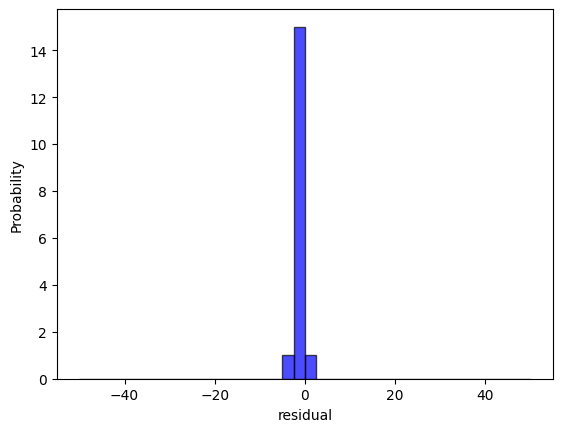

In [14]:
if __name__ == "__main__":
    warnings.filterwarnings('ignore')
    trials = Trials()
    best = fmin(fn=algorithm,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials = trials)
    # convert to dict
    params = space_eval(space, best)
    print("Best: {}".format(params))
    data = handle_datasets(file_name=file_name,train_split=0.8)
    train(data, params)